In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
import pandas as pd
plt.ion()
device = ("cuda" if torch.cuda.is_available() else "cpu")
use_gpu = torch.cuda.is_available()

# split Data

In [24]:
df = pd.read_csv('./image_attributes_filtered.csv')

In [21]:
df['Male']

0       1
1       1
2       1
3       1
4      -1
       ..
4995   -1
4996   -1
4997   -1
4998   -1
4999    1
Name: Male, Length: 5000, dtype: int64

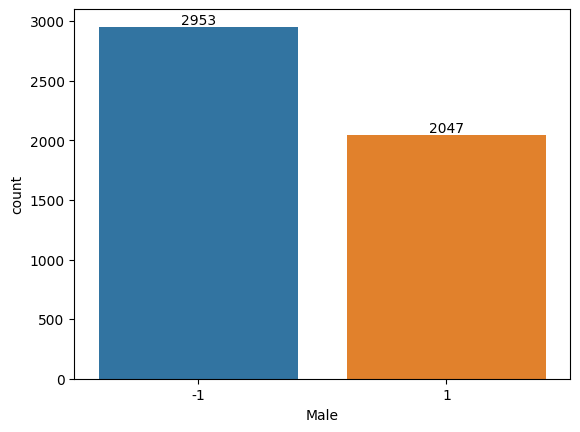

In [22]:
ax = sns.countplot(x='Male', data=df)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.show()

In [25]:
import shutil
from sklearn.model_selection import train_test_split
import os

# Path to the images folder
images_folder = './Dataset/images'

# Path to the new dataset folder
new_dataset_folder = "Dataset/train_test"
os.makedirs(new_dataset_folder, exist_ok=True)

# List all the classes in the dataset
classes = [-1, 1]  # Assuming -1 represents female and 1 represents male

# Specify the split proportions (70% training, 30% testing)
train_ratio = 0.7

# Create 'train' and 'test' directories inside the 'train_test' folder
train_data_folder = os.path.join(new_dataset_folder, "train")
test_data_folder = os.path.join(new_dataset_folder, "test")
os.makedirs(train_data_folder, exist_ok=True)
os.makedirs(test_data_folder, exist_ok=True)

# Iterate over the classes, split the images, and move them to respective directories
for class_name in classes:
    image_files = df[df['Male'] == class_name]['image_id'].tolist()

    # Split the image files into training and testing sets
    train_files, test_files = train_test_split(image_files, test_size=1 - train_ratio, random_state=42)

    # Create the necessary directories in the new dataset folder for the split
    train_folder = os.path.join(train_data_folder, "male" if class_name == 1 else "female")
    test_folder = os.path.join(test_data_folder, "male" if class_name == 1 else "female")
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move the files to their respective split directories in the new dataset folder
    for file in train_files:
        image_path = os.path.join(images_folder, file)
        shutil.copyfile(image_path, os.path.join(train_folder, file))
    for file in test_files:
        image_path = os.path.join(images_folder, file)
        shutil.copyfile(image_path, os.path.join(test_folder, file))

# Data Transform

In [27]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = new_dataset_folder  # Update to the new dataset folder path
# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [28]:
print(dataset_sizes)

{'train': 3499, 'test': 1501}


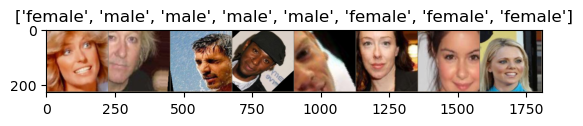

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# GoogleNet

## Train

In [4]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                

                # backward + optimize only if in training phase
                if phase == 'train':
                    _, preds = torch.max(outputs.logits, 1)
                    loss = criterion(outputs.logits, labels)
                    loss.backward()
                    optimizer.step()
                else:
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                torch.save(state,'./point_googlenet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.logits, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [9]:
use_gpu = torch.cuda.is_available()
model_ft = models.googlenet() # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)      # changing the last layer for this dataset by setting last layer neurons to 200 as this dataset has 200 categories
 
if use_gpu:                                 # if gpu is available then use it
    model_ft = model_ft.cuda()       
#model_ft = model_ft.float()
criterion = nn.CrossEntropyLoss()           # defining loss function

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

d:\conda\lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=50)

Epoch 0/49
----------
train Loss: 0.0841 Acc: 0.5975
test Loss: 0.0797 Acc: 0.6587

Epoch 1/49
----------
train Loss: 0.0817 Acc: 0.6260
test Loss: 0.0773 Acc: 0.6651

Epoch 2/49
----------
train Loss: 0.0798 Acc: 0.6362
test Loss: 0.0772 Acc: 0.6699

Epoch 3/49
----------
train Loss: 0.0772 Acc: 0.6588
test Loss: 0.0655 Acc: 0.7370

Epoch 4/49
----------
train Loss: 0.0685 Acc: 0.7178
test Loss: 0.0509 Acc: 0.7914

Epoch 5/49
----------
train Loss: 0.0637 Acc: 0.7397
test Loss: 0.0524 Acc: 0.7922

Epoch 6/49
----------
train Loss: 0.0591 Acc: 0.7741
test Loss: 0.0393 Acc: 0.8481

Epoch 7/49
----------
train Loss: 0.0570 Acc: 0.7794
test Loss: 0.0420 Acc: 0.8529

Epoch 8/49
----------
train Loss: 0.0544 Acc: 0.7898
test Loss: 0.0349 Acc: 0.8745

Epoch 9/49
----------
train Loss: 0.0537 Acc: 0.7938
test Loss: 0.0399 Acc: 0.8457

Epoch 10/49
----------
train Loss: 0.0507 Acc: 0.8103
test Loss: 0.0301 Acc: 0.8881

Epoch 11/49
----------
train Loss: 0.0482 Acc: 0.8181
test Loss: 0.0289 Acc

## Model Evaluation

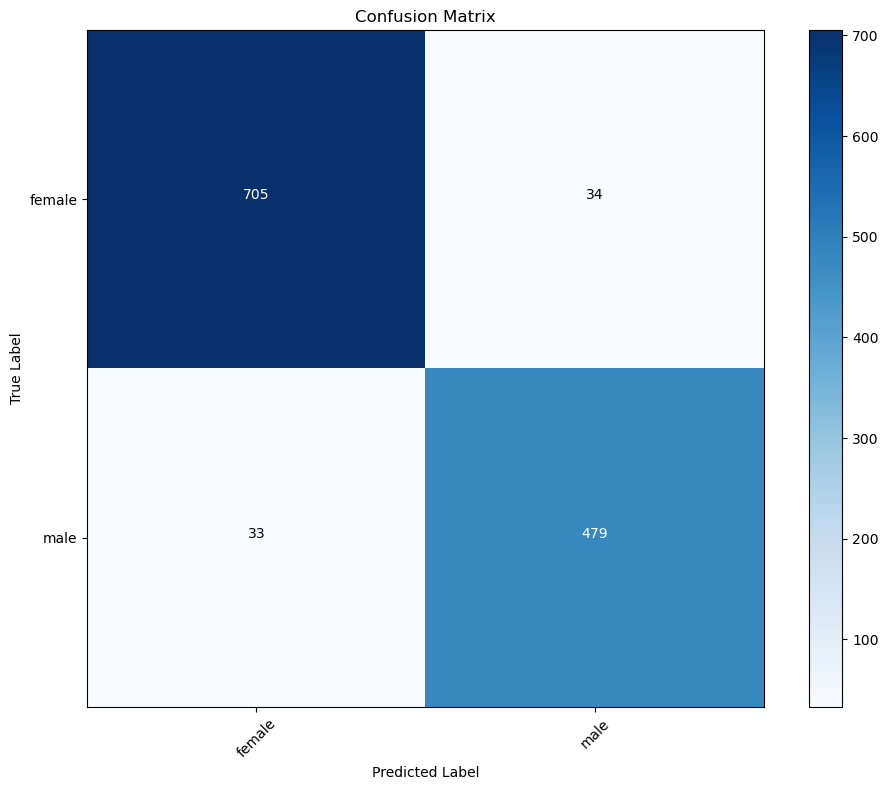

In [21]:
from sklearn.metrics import confusion_matrix

# Compute the predicted labels for the test set
model_ft.eval()  # Set the model to evaluation mode
predicted_labels = []
true_labels = []

for inputs, labels in dataloaders['test']:
    if use_gpu:
        inputs = inputs.cuda()
        labels = labels.cuda()
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    predicted_labels.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add values to the cells of the confusion matrix
thresh = confusion_mat.max() / 2
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

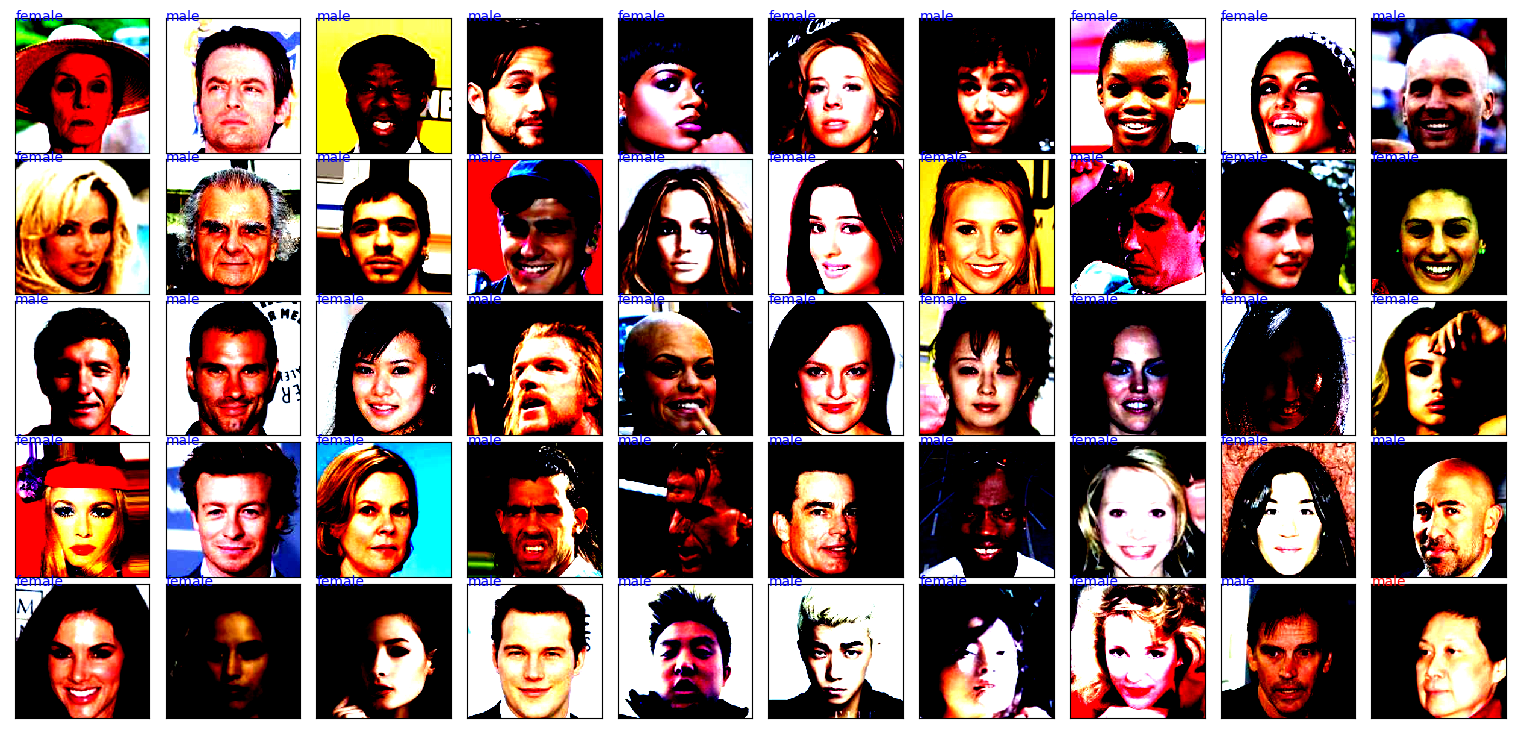

In [22]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

num_images = len(dataloaders['test'].dataset)

test_iter = iter(dataloaders['test'])
for i in range(num_images):
    images, labels = next(test_iter)

    with torch.no_grad():
        images = images.to(device)
        pred = model_ft(images)

    images_np = [img.cpu() for img in images]
    
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[0].permute(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[0] == torch.max(pred[0], 0)[1]:
        ax.text(0, 3, class_names[torch.max(pred[0], 0)[1]], color='blue')
    else:
        ax.text(0, 3, class_names[torch.max(pred[0], 0)[1]], color='red')

    if i == 49:
        break

In [8]:
visualize_model(model=model_ft)

AttributeError: 'Tensor' object has no attribute 'logits'

<Figure size 640x480 with 0 Axes>

: 

# ResNet

In [5]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                torch.save(state,'./point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [5]:
use_gpu = torch.cuda.is_available()
model_ft = models.resnet18() # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)      # changing the last layer for this dataset by setting last layer neurons to 200 as this dataset has 200 categories
 
if use_gpu:                                 # if gpu is available then use it
    model_ft = model_ft.cuda()       
#model_ft = model_ft.float()
criterion = nn.CrossEntropyLoss()           # defining loss function

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=50)

Epoch 0/49
----------
train Loss: 0.0849 Acc: 0.6007
test Loss: 0.0781 Acc: 0.6579

Epoch 1/49
----------
train Loss: 0.0787 Acc: 0.6540
test Loss: 0.0786 Acc: 0.6771

Epoch 2/49
----------
train Loss: 0.0765 Acc: 0.6575
test Loss: 0.0666 Acc: 0.7218

Epoch 3/49
----------
train Loss: 0.0730 Acc: 0.6855
test Loss: 0.0633 Acc: 0.7466

Epoch 4/49
----------
train Loss: 0.0696 Acc: 0.7151
test Loss: 0.0554 Acc: 0.7922

Epoch 5/49
----------
train Loss: 0.0646 Acc: 0.7341
test Loss: 0.0531 Acc: 0.8074

Epoch 6/49
----------
train Loss: 0.0589 Acc: 0.7655
test Loss: 0.0402 Acc: 0.8473

Epoch 7/49
----------
train Loss: 0.0538 Acc: 0.7922
test Loss: 0.0359 Acc: 0.8729

Epoch 8/49
----------
train Loss: 0.0501 Acc: 0.8098
test Loss: 0.0325 Acc: 0.8897

Epoch 9/49
----------
train Loss: 0.0475 Acc: 0.8229
test Loss: 0.0324 Acc: 0.8857

Epoch 10/49
----------
train Loss: 0.0456 Acc: 0.8341
test Loss: 0.0259 Acc: 0.9113

Epoch 11/49
----------
train Loss: 0.0437 Acc: 0.8397
test Loss: 0.0222 Acc

## Model Evaluation

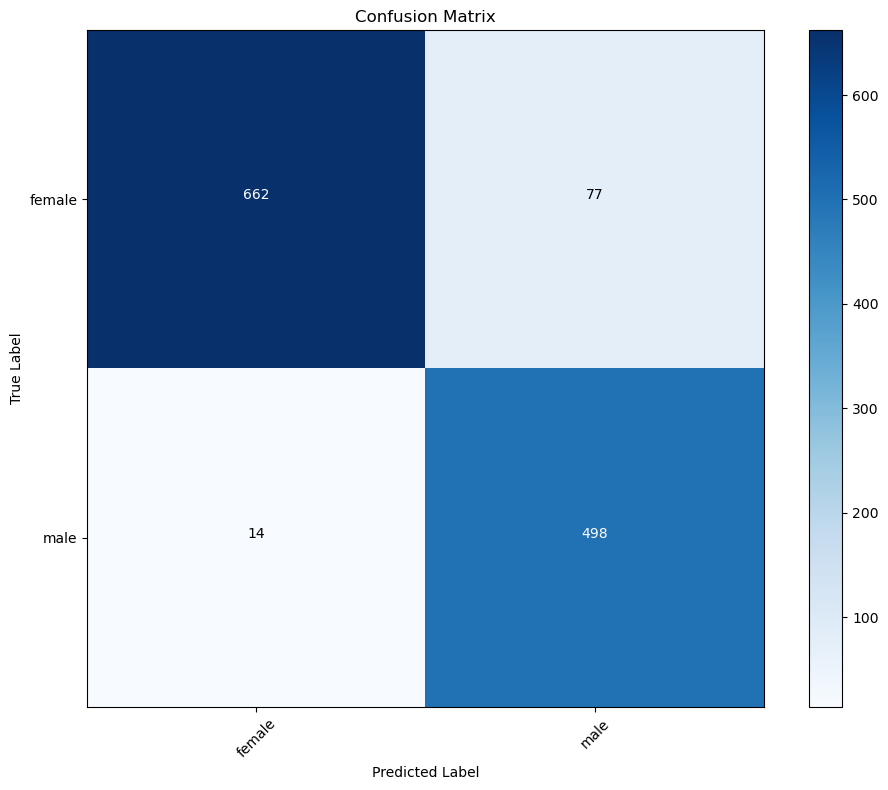

In [9]:
from sklearn.metrics import confusion_matrix

# Compute the predicted labels for the test set
model_ft.eval()  # Set the model to evaluation mode
predicted_labels = []
true_labels = []

for inputs, labels in dataloaders['test']:
    if use_gpu:
        inputs = inputs.cuda()
        labels = labels.cuda()
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    predicted_labels.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add values to the cells of the confusion matrix
thresh = confusion_mat.max() / 2
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

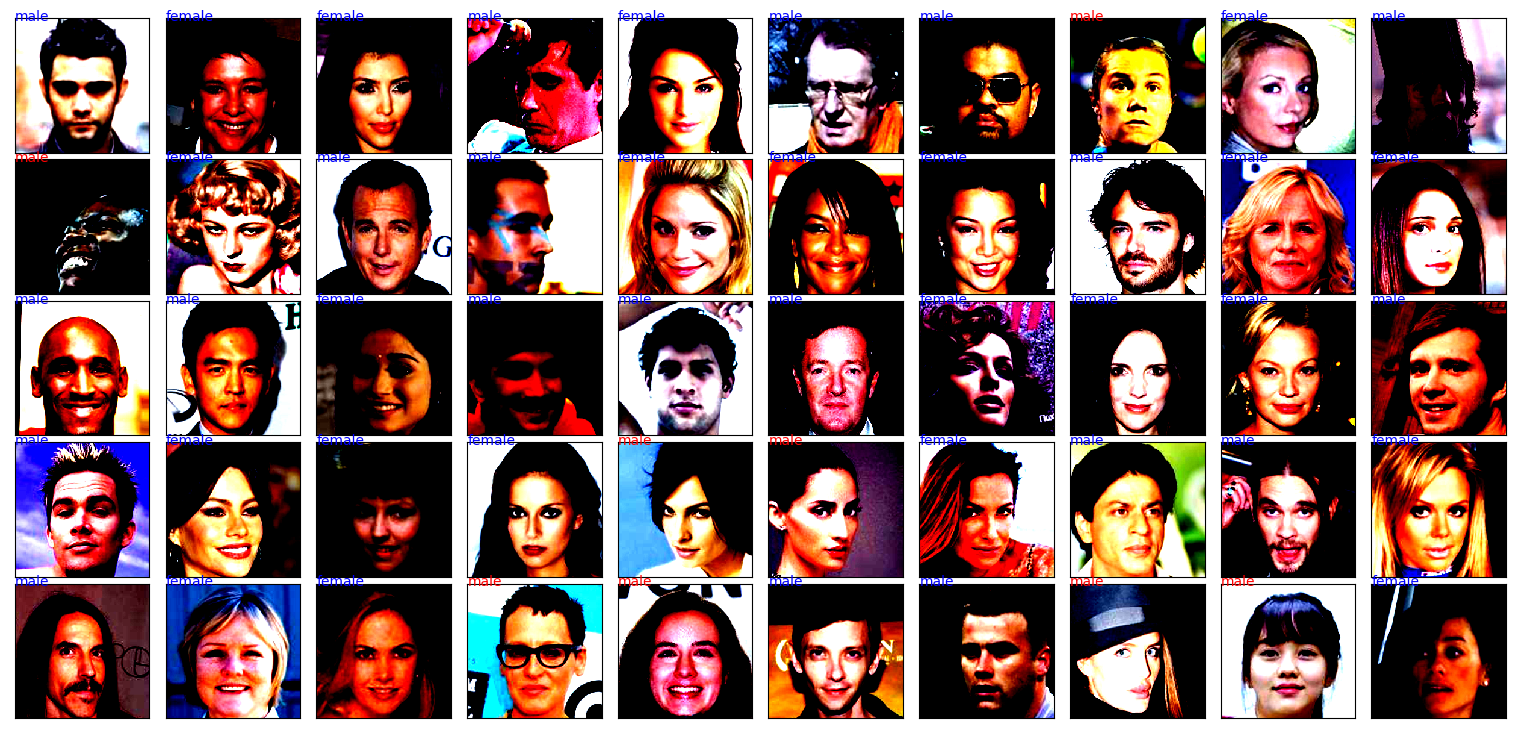

: 

In [10]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

num_images = len(dataloaders['test'].dataset)

test_iter = iter(dataloaders['test'])
for i in range(num_images):
    images, labels = next(test_iter)

    with torch.no_grad():
        images = images.to(device)
        pred = model_ft(images)

    images_np = [img.cpu() for img in images]
    
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[0].permute(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[0] == torch.max(pred[0], 0)[1]:
        ax.text(0, 3, class_names[torch.max(pred[0], 0)[1]], color='blue')
    else:
        ax.text(0, 3, class_names[torch.max(pred[0], 0)[1]], color='red')

    if i == 49:
        break